In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D 
import math

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

<h3>Question</h3>
A satellite is flying about the Earth on an elliptic orbit.  The initial inertial position vector is

$$ r(t_0) = (2466.69,5941.54,3282.71) \text{km} $$

while the initial inertial velocity is 

$$ v(t_0) = (−6.80822,1.04998,3.61939) \text{km/s} $$

Determine the inertial position and velocity vectors 60 minutes later by writing a numerical simulation to integrate the unperturbed orbital differential equations of motion.

<h4>Notes</h4>

Answering this question with numpy, scipy.integrate, and matplotlib (for sanity checking our orbit) would prove pretty trivial. I'll show my brute force bare-bones solution first. 

As for numerical integrators, we have quite a few options. RK4 would make sense, but symplectic Euler is easy to code, so let's go with that!

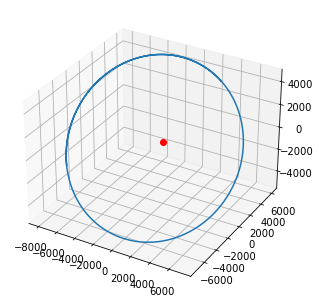

In [12]:
'''
Symplectic Euler integration of r, v.
'''

# constants
step_size = 1.0
steps = 10000
mu = 3.986004418e5

def eom(step_size, N):
    # constants
    r_0 = [2466.69,5941.54,3282.71] # km Note: need to add Earth radius?
    v_0 = [-6.80822,1.04998,3.61939] # km/s

    r = [ [None for y in range(3) ] for x in range(N)]
    v = [ [None for y in range(3) ] for x in range(N)]
    r[0] = r_0
    v[0] = v_0

    for n in range(N-1):
        # compute magnitude of position vector 
        r_vec = math.sqrt(r[n][0]**2 + r[n][1]**2 + r[n][2]**2)

        # compute velocities
        v[n+1][0] = v[n][0] - step_size * (mu * r[n][0]) / r_vec**3
        v[n+1][1] = v[n][1] - step_size * (mu * r[n][1]) / r_vec**3
        v[n+1][2] = v[n][2] - step_size * (mu * r[n][2]) / r_vec**3

        # compute positions
        r[n+1][0] = r[n][0] + step_size * v[n+1][0]
        r[n+1][1] = r[n][1] + step_size * v[n+1][1]
        r[n+1][2] = r[n][2] + step_size * v[n+1][2]
        
    return(r, v)

r,v = eom(step_size, steps)

# plot
fig = plt.figure()
ax = Axes3D(fig)
x = np.array([])
y = np.array([])
z = np.array([])
for i in range(steps):
    x = np.append(x, r[i][0])
    y = np.append(y, r[i][1])
    z = np.append(z, r[i][2])

ax.plot(x, y, z)
ax.plot([0], [0], [0], "ro")

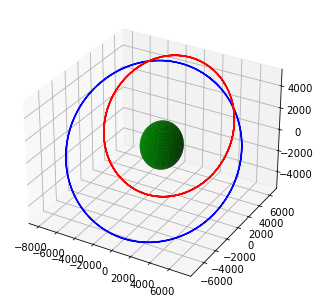

In [15]:
'''
Numerical inteegration of r, v using scipy.
'''
# system 1
r_0 = [2466.69,5941.54,3282.71] # km
v_0 = [-6.80822,1.04998,3.61939] # km/s

# system 2
r_1 = [3200.6,6000.68,3433.2] # km
v_1 = [-4.80822,2.04998,3.61939] # km/s

# Equations of Motion
def eom(t, y):
    # initial conditions
    r = y[:3]
    v = y[3:]

    # result vector
    res = np.zeros_like(y)
    res[:3] = v

    mu = 3.986004418e5 # G*M
    r_mag = np.sqrt(np.sum(np.square(r)))
    a = (- mu * r) / r_mag**3 
    res[3:] = a
    return res

# system 1
state_1 = np.hstack((r_0, v_0))
t_0 = 0 # s
t_f = 14400 # s
t_points = np.linspace(t_0, t_f, 10000)

sol = solve_ivp(eom, [t_0, t_f], state_1, t_eval=t_points, method="DOP853")

y = sol.y.T
R = y[: ,:3]
V = y[:, 3:]

# system 2
state_2 = np.hstack((r_1, v_1))

sol1 = solve_ivp(eom, [t_0, t_f], state_2, t_eval=t_points, method="DOP853")

y1 = sol1.y.T
R1 = y1[: ,:3]
V1 = y1[:, 3:]

# plot
fig =  plt.figure()
ax = Axes3D(fig)
ax.plot(R[:, 0], R[:, 1], R[:, 2], "blue")
ax.plot(R1[:, 0], R1[:, 1], R1[:, 2], "red")

# surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi * 1, 100)
x = 2000 * np.outer(np.cos(u), np.sin(v))
y = 2000 * np.outer(np.sin(u), np.sin(v))
z = 2000 * np.outer(np.ones(np.size(u)), np.cos(v))

# plot the surface
ax.plot_surface(x, y, z, color="green")

<h3>Question</h3>

Assume the initial satellite inertial position vector is 

$$ r(t_0) = (2466.69,5941.54,3282.71)km $$

and the inertial velocity vector is

$$ v(t_0) = (−6.80822,1.04998,3.61939)km/sec $$

If at time t the velocity vector is

$$ v(t) = (5.57433,−0.92203,−3.00873)km/sec $$

what is the unit vector pointing from the Earth to the satellite at time t?


<h4>Reasoning</h4>

We have the initial position and velocity, so we can compute the eccentricity and the angular momentum--both of which are conserved in our unperturbed orbit. Because these quantities are conserved, we can manipulate the eccentricity vector expression in order to solve for the unit vector at any arbitrary later time, as long as we have the velocity vector at that time 

$$ \textbf{e} = \frac{\dot{\textbf{r}} \times \textbf{h} }{\mu} - \frac{\textbf{r}}{r} $$

Notice that 

$$ \hat{r} = \frac{\textbf{r}}{r} $$

So we can solve for the unit vector to get 

$$ \hat{r} = \frac{\textbf{r}}{r} = \frac{\dot{\textbf{r}} \times \textbf{h} }{\mu} - \textbf{e} $$

We already have velocity, so we just need to compute the eccentricity and angular momentum.

In [17]:
r_0 = [2466.69,5941.54,3282.71] # km 
v_0 = [-6.80822,1.04998,3.61939] # km/s
v_t = [5.57433,-0.92203,-3.00873] # km/s
mu = 3.986004418e5

# ang momentum
# we could compute it manually, if we wanted to:
# def h(r, v):
#     return [
#         (r[1]*v[2]-r[2]*v[1]), (r[2]*v[0]-r[0]*v[2]), (r[0]*v[1]-r[1]*v[0])
#     ]
h = np.cross(r_0, v_0)

# eccentricity
e = (np.cross(v_0, h) / mu) - (r_0 / np.linalg.norm(r_0))

# r_hat at time t 
r_hat = (np.cross(v_t, h) / mu) - e
print("r-hat: ", r_hat)

r-hat:  [-0.39149943 -0.81469931 -0.42777369]


<h2>Question</h2>

A satellite is orbiting Earth with a semi-major axis of 7500 km and an eccentricity of 0.05.  The initial true anomaly is f(t) = 25 degrees.  What is the true anomaly 1 hour later?  Provide your answer in radians, and keep the angle between 0 and 2π.

In [19]:
'''
Given an initial true anomaly and some orbit properties, 
calculate a later true anomaly at time t.

params:
- f_initial: initial true anomaly (rad)
- a : semi-major axis (km)
- eccentricity

'''
dt = 3600 # s
mu = 3.986004418e5

def evolve_f(f_0, a, e, dt):
    # constants
    nu = np.sqrt(mu / a**3)

    # compute eccentric anomaly at t_0
    E_0 = 2 * np.arctan(np.sqrt((1-e) / (1+e)) * np.tan(f_0 / 2))

    # compute mean anomaly at t_0
    M_0 = E_0 - e * np.sin(E_0)

    # compute mean anomaly at t_f
    M_f = M_0 + (nu*dt)

    # apply Newton's method to get E_f from M_f
    E_f = M_f
    for i in range(0, 10):
        E_f = E_f - ((E_f - M_f - e * np.sin(E_f)) / (1 - e * math.cos(E_f)))

    # compute true anomaly at t_f
    F = 2 * math.atan(math.sqrt((1+e)/(1-e)) * math.tan(E_f/2))

    # normalize between 0 and 2pi
    return F % (2*np.pi)
    
evolve_f(np.deg2rad(25), 7500, 0.05, dt)
    

3.8293933033330942

<h2>Question</h2>

Write a subroutine to convert the following elements and true anomaly to the equivalent inertial position and velocity vector states.  The method inputs should be

$$ \mu, a, e, i, \Omega, \omega, f $$

To validate the conversion from orbit elements to cartesian states is working, input below the response for a case where an Earth orbiting satellite has a=8000km, e=0.1, i=30degrees, w=120degrees, M(t_0)=10degrrees. Find the oe states one hour later and determine the corresponding inertial position and velocity vector.

<h3>Reasoning</h3>

Let's enumerate the steps that are required to get the state vector (r, v). 

0. evolve the state of the system from time 0 (epoch) to the time being asked for in the question, namely an hour later (3600 seconds). 
1. compute the position and velocity vetors in perifocal coordinates.
2. determine the rotation matrix to transform perifocal coordinates into geocentric-equatorial coordinates.
3. compute the position and velocity vectors in the geocentric frame by applying the matrix. 

In [77]:
# constants
a = 8000 #km
e = 0.1 
i = 30 # degrees
O = 145 # Omega, degrees
w = 120 # degrees
M_0 = 10 # degrees, at epoch
dt = 3600 # seconds
mu = 3.986004418e5 # km**3 / s**2

def inverse_kepler(E_0, iter):
    E_n = E_0
    for i in range(0, iter):
        E_n = E_n - ((E_n - E_0 - e * np.sin(E_n)) / (1 - e * math.cos(E_n)))
    return E_n

def elem_to_state(a, e, i, O, w, mu):
    # STEP 0: evolve system and compute salient quantities
    nu = np.sqrt(mu / a**3)
    M_0 = np.deg2rad(10)
    M_t = M_0 + nu * dt
    E = inverse_kepler(M_t, 10)

    # compute true anomaly
    F = 2 * math.atan(math.sqrt((1+e)/(1-e)) * math.tan(E/2))
    print(np.rad2deg(F))
    F = F % (2*np.pi)
    F = np.rad2deg(F)
    print(F)
    theta = w + F
    p = a * (1 - e**2)
    h = np.sqrt(p*mu)
    
    # STEP 1: compute perifocal
    r_p = ((h**2/mu) / (1+e*np.cos(F))) * np.array([
        np.cos(F),
        np.sin(F),
        0
    ])

    v_p = mu/h * np.array([
        -np.sin(F),
        (e + np.cos(F)),
        0
    ])

    # print(r_p, v_p)
    # print(theta, O, i, w)
    r = np.linalg.norm(r_p) * np.array([
        (np.cos(O) * np.cos(theta)) - (np.sin(O) * np.sin(theta) * np.cos(i)),
        (np.sin(O) * np.cos(theta)) + (np.cos(O) * np.sin(theta) * np.cos(i)),
        (np.sin(theta) * np.sin(i))
    ])

    v = -mu/h * np.array([
        (np.cos(O)*(np.sin(theta) + e*np.sin(w))) + (np.sin(O)*(np.cos(theta) + e*np.cos(i))*np.cos(i)),
        (np.sin(O)*(np.sin(theta) + e* np.sin(w))) - (np.cos(O)*(np.cos(theta) + e*np.cos(w))*np.cos(i)),
        -(np.cos(theta) + e*np.cos(w))*np.sin(i)
    ])

    print(r, v)


state = elem_to_state(a, e, i, O, w, mu)

#    rVec = [ -1264.61972, 8013.80891, -3371.24746        ]   # km
#     vVec = [-6.03962278, -.204407116, 2.09672014]  # km/sec

-170.1257813314099
189.8742186685901
[-3357.19151146  -542.31895663 -6988.05123754] [-5.86627526 -3.53466585  2.33435892]


<h2>Question</h2>

Write a subroutine to convert the inertial position and velocity vector components to the corresponding classical orbit elements. The subroutine inputs should be

$$ \mu, ^N\textbf{r}, ^N\textbf{v} $$

To test the subroutine, assume the satellite is orbiting the Earth with the current inertial states

$$ ^N\textbf{r} = (-820.865,-1905.95,-7445.)km $$

$$ ^N\textbf{v} = (-6.75764,-1.85916,0.930651)km/s  $$

Return the corresponding orbit elements a, e, i, Ω, ω, f. Express any angles in the (-π, π) range.

In [119]:
r = np.array((-820.865,-1905.95,-7445.9)) # km, inertial N frame
v = np.array((-6.75764,-1.85916,0.930651)) # km/s, inertial N frame
mu = 3.986004418e5 # km**3 / s**2

def state_to_elem(r, v, mu):
    # compute angular momentum, eccentricity, and vector magnitudes
    h_vec = np.cross(r, v)
    r_mag = np.linalg.norm(r)
    v_mag = np.linalg.norm(v)
    h_mag = np.linalg.norm(h_vec)

    e = (np.dot((v_mag**2 - mu / r_mag), r) - (np.dot(np.dot(r, v), v))) / mu
    e_mag = np.linalg.norm(e)

    # semi maajor axis
    a = 1 / (2/r_mag - v_mag**2/mu)

    # inclination
    i = np.arccos(h_vec[2] / h_mag)

    # RAAN
    k = np.array((0, 0, 1))
    n_vec = np.cross(k, h_vec)
    n_mag = np.linalg.norm(n_vec)
    O = 0
    if n_vec[1] > 0: 
        O = np.arccos(n_vec[0] / n_mag)
    else: 
        O = 2*np.pi - np.arccos(n_vec[0] / n_mag)

    # argument of perigee
    w = np.arccos(np.dot(n_vec, e) / (n_mag * e_mag))

    # true anomaly
    f = np.arccos(np.dot(e, r) / (e_mag*r_mag))

    print("semi major axis", a, "\neccentricity", e_mag, "\ninclination", i, "\nright ascension", O, "\nargument of periapsis", w, "\ntrue anomaly", f)

    return (a, e_mag, i, O, w, f)

state = state_to_elem(r, v, mu)

semi major axis 7499.987950868796 
eccentricity 0.050000674203091636 
inclination 1.7802354681838837 
right ascension 3.438298118471714 
argument of periapsis 2.6179658909673256 
true anomaly 2.268955750997619


[[-1.26461972e+03]
 [ 8.01380891e+03]
 [-3.37124746e+03]
 [-6.03962278e+00]
 [-2.04407116e-01]
 [ 2.09672014e+00]]
